# Quantifying multiple loci editing efficiency of the Eco1RT - Cas9 system

### Import packages

In [1]:
import sys,os, glob
import shutil

import matplotlib as plt
plt.rcParams['pdf.fonttype'] = 42

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import seaborn as sns

from Bio import SeqIO
import fuzzysearch
import re
from collections import Counter, OrderedDict
from Bio.Seq import Seq

In [2]:
run = "./miseq/msSBK_19-281139926/FASTQ_Generation_2021-07-16_19_31_05Z-439441004"
#ref = "ADE2.fa"
os.chdir(run)

### load dataframe of sample ID and conditions 

In [3]:
samples = pd.read_excel("samples.xlsx")[["sample_name", "Description", "Sub-Library Owner"]]
samples

,sample_name,Description,Sub-Library Owner
0,msSBK_19_01,ySCL59-1 (mKate) recombineering induced,SCL
1,msSBK_19_02,ySCL59-2 (mKate) recombineering induced,SCL
2,msSBK_19_03,ySCL59-3 (mKate) recombineering induced,SCL
3,msSBK_19_04,ySCL59-4 (mKate) recombineering induced,SCL
4,msSBK_19_05,ySCL90-1 (pSLS703) recombineering uninduced,SCL
...,...,...,...
194,NaN,NaN,Sequence:
195,NaN,NaN,AATGATACGGCGACCACCGAGATCTACACTAGATCGCTCGTCGGCA...
196,NaN,NaN,AATGATACGGCGACCACCGAGATCTACACCTCTCTATTCGTCGGCA...
197,NaN,NaN,CAAGCAGAAGACGGCATACGAGATTCGCCTTAGTCTCGTGGGCTCG...


In [9]:
print ("="*60)
for file in glob.glob("msSBK_19_*"):
    fn = file.split("_L001")[0]
    condition = samples["description"][samples["sample_name"]==fn].to_string(index=False)
    owner = samples["Sub-Library Owner"][samples["sample_name"]==fn].to_string(index=False)
    if "SCL" in owner:

        print (fn + " -- " + condition)
        os.chdir(file)
        r1 = glob.glob("*R1_001*")[0]
        print (r1)
        print ("\ntrimming files\n")
        cmd = "sickle se -f {0} -t sanger \
                -o trimmed_R1.fastq".format(r1)
        os.system(cmd)    
        print ("="*60)

        os.chdir(run)
        
    else:
        shutil.rmtree(file, ignore_errors=True)
os.chdir(run)

msSBK_18_50 --  HEK293T + 115 8 days
msSBK-18-50_S50_L001_R1_001.fastq.gz

trimming files

msSBK_18_43 --  HEK293T + 116 5 days
msSBK-18-43_S43_L001_R1_001.fastq.gz

trimming files

msSBK_18_81 --  ySCL83 24h R2
msSBK-18-81_S81_L001_R1_001.fastq.gz

trimming files

msSBK_18_108 --  ySCL84 48h R2
msSBK-18-108_S108_L001_R1_001.fastq.gz

trimming files

msSBK_18_103 --  ySCL82 48h R3
msSBK-18-103_S103_L001_R1_001.fastq.gz

trimming files

msSBK_18_107 --  ySCL84 48h R1
msSBK-18-107_S107_L001_R1_001.fastq.gz

trimming files

msSBK_18_29 --  HEK293T + 83 3 days
msSBK-18-29_S29_L001_R1_001.fastq.gz

trimming files

msSBK_18_164 --  ySCL91 (pSLS704) recombineering Ade2 100ul
msSBK-18-164_S164_L001_R1_001.fastq.gz

trimming files

msSBK_18_99 --  ySCL81 48h R2
msSBK-18-99_S99_L001_R1_001.fastq.gz

trimming files

msSBK_18_30 --  HEK293T + 84 3 days
msSBK-18-30_S30_L001_R1_001.fastq.gz

trimming files

msSBK_18_21 --  ySCL39 24h
msSBK-18-21_S21_L001_R1_001.fastq.gz

trimming files

msSBK_18_85 

### parse files and pull indel profile

In [4]:
# define genomic region of interest
Region_dict = {'CAN1': {'flanking': ['CTTTGGCTTACATGGAGACA','AAAGTTTTCGAATGGCTATT'], 'wt_or_edited': ['TCTACTGGTGGTGAC','TCTACTTGAGGTGAC']},
               'LYP1': {'flanking': ['AACAACATTGGCGAACAGAG','AGAAGACCAGATAGAACATG'], 'wt_or_edited': ['CATGCAGGAATTACC','CATGCAGTAATTACC']},
               'TRP2': {'flanking': ['CCTGATAGAAAGGAATCATT','TAAGACAAATAATGAATTAG'], 'wt_or_edited': ['TCTGTTGGAAAGTGC','TCTGTTGTAAAGTGC']},
               'FAA1': {'flanking': ['CCATCAACAGAATTAAAGAA','AAGACCTTTAGCTTTGACGA'], 'wt_or_edited': ['GTTAGACCTGATATC','GTTAGATGAGATATC']}}

def extract_and_exact_match(sequence):
	left_flank = fuzzysearch.find_near_matches(Region_dict[edit_site]['flanking'][0],sequence,max_l_dist=0)
	right_flank = fuzzysearch.find_near_matches(Region_dict[edit_site]['flanking'][1],sequence,max_l_dist=0)
	if len(left_flank) == 1 and len(right_flank) == 1:
		region = sequence[left_flank[0].end:right_flank[0].start]
		if region == Region_dict[edit_site]['wt_or_edited'][0]:
			return ('wt', region)
		elif region == Region_dict[edit_site]['wt_or_edited'][1]:
			return ('edited', region)
		else: return ('undetermined_no_site_match', region)
	else: return ('undetermined_no_flanking_match', None)

In [13]:
os.chdir(run)

df_exact_files = pd.DataFrame(columns=["sample_name", "condition", "wt", "edited",
                                 "undetermined_no_flanking_match", 'undetermined_no_site_match',
                                 "total reads", "edited_percent"])
fastq_reads = "trimmed_R1.fastq"
edit_site = "FAA1"
print ("="*60)

non_precise_exact = {}
for file in glob.glob("msSBK_19_*"):
    fn = file.split("_L001")[0]
    condition = samples["Description"][samples["sample_name"]==fn].to_string(index=False)
    if (("ySCL84" in condition) or ("ySCL85" in condition)):
        non_precise_exact[condition] = []
print (non_precise_exact)

for file in glob.glob("msSBK_19_*"):
    fn = file.split("_L001")[0]
    condition = samples["Description"][samples["sample_name"]==fn].to_string(index=False)
    if (("ySCL84" in condition) or ("ySCL85" in condition)):
        npe = []
        all_reads_str = []
        outcomes_dict = {'wt':0,
                     'edited':0,
                     'undetermined_no_flanking_match':0,
                     'undetermined_no_site_match':0}

        print (fn + " -- " + condition)
        os.chdir(file)

        filename = glob.glob("*.fastq.gz")

        for seq_record in SeqIO.parse(fastq_reads, "fastq"):
            all_reads_str.append(str(seq_record.seq))
        read_counter = Counter(all_reads_str)
        for read in read_counter:
            if extract_and_exact_match(read)[0]=='undetermined_no_site_match':
                #print (extract_and_exact_match(read)[1])
                npe.extend([extract_and_exact_match(read)[1]]*read_counter[read])
                #print (npe)
                
            outcomes_dict[extract_and_exact_match(read)[0]] += read_counter[read] 
        try:
            edited_percent = (float(outcomes_dict['edited'])/float(outcomes_dict['edited']+outcomes_dict['wt']))*100
        except:
            print (float(outcomes_dict['edited']), float(outcomes_dict['edited']), outcomes_dict['wt'])
            edited_percent = 0

        print ('{0} percent edited ({1} edited/ {2} wt)'.format(edited_percent,outcomes_dict['edited'],outcomes_dict['wt']))
        print ('{0} do not contain clean flanking regions'.format(outcomes_dict['undetermined_no_flanking_match']))
        print ('{0} contain flanking regions, but not a clean target site match to edited or wt'.format(outcomes_dict['undetermined_no_site_match']))
        print ("parsing done.\n"+ "="*60 + "\n")

        df_exact_files = df_exact_files.append({"sample_name": fn, "condition": condition, 
                                     "wt": outcomes_dict['wt'], "edited": outcomes_dict['edited'],
                                     "undetermined_no_flanking_match": outcomes_dict['undetermined_no_flanking_match'],
                                     'undetermined_no_site_match': outcomes_dict['undetermined_no_site_match'],
                                     "total reads": outcomes_dict['wt'] + outcomes_dict["edited"] + outcomes_dict['undetermined_no_flanking_match'] + outcomes_dict['undetermined_no_site_match'],
                                     "edited_percent": edited_percent, 
                                     "non_precise_edits_percent": outcomes_dict['undetermined_no_site_match']/(outcomes_dict['wt'] + outcomes_dict["edited"] + outcomes_dict['undetermined_no_flanking_match'] + outcomes_dict['undetermined_no_site_match'])*100},
                                    ignore_index=True,)
        #print (npe)
        non_precise_exact[condition]+=npe
    os.chdir(run)

{' ySCL85 24h R3': [], ' ySCL84 48h R1': [], ' ySCL85 24h R2': [], ' ySCL85 48h R1': [], ' ySCL85 24h R1': [], ' ySCL85 48h R3': [], ' ySCL84 24h R3': [], ' ySCL84 24h R2': [], ' ySCL84 24h R1': [], ' ySCL84 48h R2': [], ' ySCL85 48h R2': [], ' ySCL84 48h R3': []}
msSBK_19_38 --  ySCL85 24h R3
89.52921429142354 percent edited (11201 edited/ 1310 wt)
33128 do not contain clean flanking regions
144 contain flanking regions, but not a clean target site match to edited or wt
parsing done.

msSBK_19_51 --  ySCL84 48h R1
99.09199166418577 percent edited (13314 edited/ 122 wt)
26291 do not contain clean flanking regions
173 contain flanking regions, but not a clean target site match to edited or wt
parsing done.

msSBK_19_37 --  ySCL85 24h R2
87.53261663709425 percent edited (16773 edited/ 2389 wt)
41390 do not contain clean flanking regions
233 contain flanking regions, but not a clean target site match to edited or wt
parsing done.

msSBK_19_82 --  ySCL85 48h R1
99.55199494017815 percent ed

## Create a dataframe to store data for plotting

In [14]:
df_exact_files[["placehold", "strain", "time", "comp"]] = df_exact_files["condition"].str.split(" ", n=4, expand = True)
df_exact_plot = df_exact_files.drop("placehold", axis=1)
df_exact_plot = df_exact_plot.sort_values("edited_percent")

# add genotype information about strains
d = {"ySCL78": "Eco1RT + Cas9 CAN1 editing wt primer",
    "ySCL79": "Eco1RT + Cas9 CAN1 editing lp",
    "ySCL80": "Eco1RT + Cas9 LYP1 editing wt primer",
    "ySCL81": "Eco1RT + Cas9 LYP1 editing lp",
    "ySCL82": "Eco1RT + Cas9 TRP2 editing wt primer",
    "ySCL83": "Eco1RT + Cas9 TRP2 editing lp",
    "ySCL84": "Eco1RT + Cas9 FAA1 editing wt primer",
    "ySCL85": "Eco1RT + Cas9 FAA1 editing lp"}
df_exact_plot["genotype"] = df_exact_plot["strain"].map(d)

display(df_exact_plot)

,sample_name,condition,wt,edited,undetermined_no_flanking_match,undetermined_no_site_match,total reads,edited_percent,non_precise_edits_percent,strain,time,comp,genotype
7,msSBK_19_34,ySCL84 24h R2,4516,9734,36704,171,51125,68.308772,0.334474,ySCL84,24h,R2,Eco1RT + Cas9 FAA1 editing wt primer
6,msSBK_19_35,ySCL84 24h R3,4025,11971,29328,182,45506,74.837459,0.399947,ySCL84,24h,R3,Eco1RT + Cas9 FAA1 editing wt primer
8,msSBK_19_33,ySCL84 24h R1,2778,8921,35621,155,47475,76.254381,0.326488,ySCL84,24h,R1,Eco1RT + Cas9 FAA1 editing wt primer
4,msSBK_19_36,ySCL85 24h R1,2104,13601,24230,202,40137,86.602993,0.503276,ySCL85,24h,R1,Eco1RT + Cas9 FAA1 editing lp
2,msSBK_19_37,ySCL85 24h R2,2389,16773,41390,233,60785,87.532617,0.383318,ySCL85,24h,R2,Eco1RT + Cas9 FAA1 editing lp
0,msSBK_19_38,ySCL85 24h R3,1310,11201,33128,144,45783,89.529214,0.314527,ySCL85,24h,R3,Eco1RT + Cas9 FAA1 editing lp
1,msSBK_19_51,ySCL84 48h R1,122,13314,26291,173,39900,99.091992,0.433584,ySCL84,48h,R1,Eco1RT + Cas9 FAA1 editing wt primer
9,msSBK_19_52,ySCL84 48h R2,154,18165,39452,234,58005,99.159343,0.403413,ySCL84,48h,R2,Eco1RT + Cas9 FAA1 editing wt primer
11,msSBK_19_81,ySCL84 48h R3,110,12975,26642,147,39874,99.159343,0.368661,ySCL84,48h,R3,Eco1RT + Cas9 FAA1 editing wt primer
10,msSBK_19_83,ySCL85 48h R2,71,15520,36018,183,51792,99.544609,0.353336,ySCL85,48h,R2,Eco1RT + Cas9 FAA1 editing lp


## Plot editing efficiency per strain and retron variant

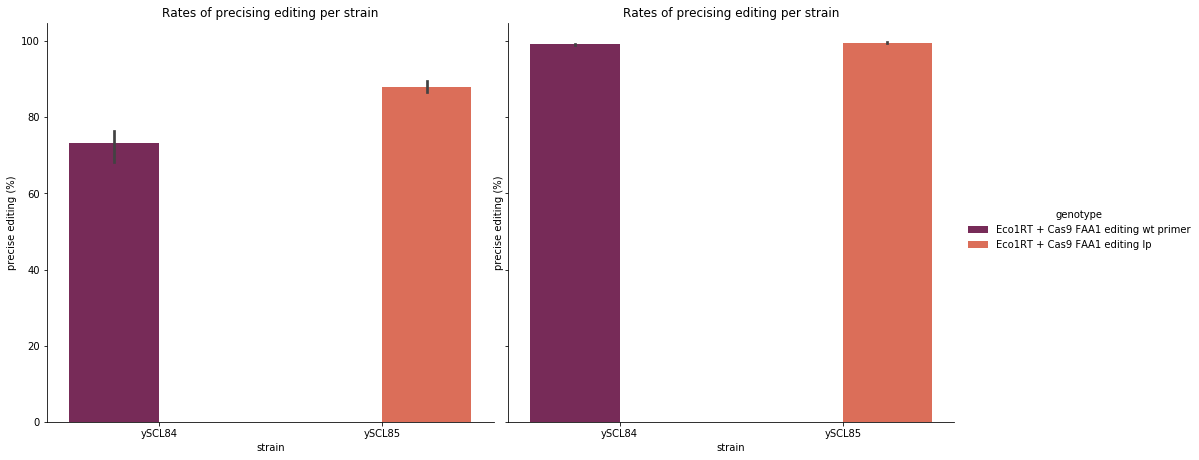

In [15]:
df_exact_plot = df_exact_plot.sort_values("edited_percent")

g = sns.catplot(x="strain", y="edited_percent", hue = "genotype", col="time", palette = "rocket", col_order=["24h", "48h"],
                data=df_exact_plot[:], kind="bar", height=6.27, aspect=6.7/6.27)


g.set(xlabel='strain', ylabel='precise editing (%)', title="Rates of precising editing per strain")
g.set_xticklabels(rotation=0)

g.savefig("FAA1_editing_percent.pdf")